# Plotting Fig 5

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics

import warnings
import matplotlib as mpl
import plot_utils
import json
from scipy import stats

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360
fliersize = 1

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
palette_tcrs = {'OTI': 'tab:green',
                'Educated': 'tab:orange',
                'Naive': 'tab:blue', 
                'Human': 'Firebrick'
               }
palette_tcrs_cmap = mpl.colors.ListedColormap(list(palette_tcrs.values()))

cmap_positions = mpl.colors.ListedColormap(['silver'] + sb.color_palette('Purples', 12)[3:])

cmap_heatmap = 'rocket'

color_base ='silver'
color_thresh = 'silver'
style_base = ':'
style_thresh = '--'

color_greedy = 'silver'
color_active = 'Firebrick'
color_random = 'grey'
color_human = palette_tcrs['Human']

palette_active = {'Active': palette_tcrs['Human'],
                  'Random': color_random,
                 }

palette_pos = sb.color_palette('Set3', 9)#[2:]
palette_pos = dict(zip([f'P{i}' for i in range(1, 11)], palette_pos))

## Load Data

In [6]:
def read_human_data(normalization='pc'):
    path_in = '../data/Affinity_prediction_rnf43_repertoire.xlsx'
    sheet = 'Normalized by PC'
    if normalization != 'pc':
        sheet = 'Individual APL screening'
    df = pd.read_excel(path_in, sheet)
    df['Mutated_position'] = df['Mutated_position'].replace({'VPSVWRSSL': 0})
    df = df[[el for el in df.columns if not el.startswith('Unnamed')]]
    
    df.index = df['Mutated_position'].astype(str) + '_' + df['Mutated AA'].astype(str)
    df = df.drop(columns=['Peptide', 'Mutated_position', 'Peptide ID', 'Mutated AA'])
    #tcrs = df.columns[4:11]
    #df = df[tcrs]
    df = df.drop(['R27'], axis=1)
    df = df.reindex(df.index[1:].tolist() + df.index[:1].tolist())
    return df

In [7]:
data_human_norm = read_human_data(normalization='pc')
data_human_unnorm = read_human_data(normalization='none')

## Load Within Prediction Results

In [8]:
def compute_metrics(g):
    return pd.Series({
        'MAE': g['abserr'].mean(),
        'R2': metrics.r2_score(g['act'], g['pred']),
        'Pearson': g['act'].corr(g['pred'], method='pearson'),
        'Spearman': g['act'].corr(g['pred'], method='spearman'),
        'AUC': (
            metrics.roc_auc_score(g['is_activated'], g['pred_prob'])
            if np.isfinite(g['pred_prob']).all() and 0 < g['is_activated'].mean() < 1
            else np.nan
        ),
        'APS': (
            metrics.average_precision_score(g['is_activated'], g['pred_prob'])
            if np.isfinite(g['pred_prob']).all()
            else np.nan
        ),
        'Spearman_class': g['act'].corr(g['pred_prob'], method='spearman'),
    })

In [9]:
def load_perf_data():        
    path_in = '../activation-prediction/results'
    ppdf = pd.read_csv(f'{path_in}/VPSVWRSSL_tcr_specific_data_size.csv.gz')    
    ppdf = ppdf[ppdf['normalization'] == 'pc']

    # compute metric for each validation fold separately
    mdf = pd.concat([
        # except for lmo CV where each validation fold contained a single sample
        # in that case we just compute a global average for each tcr
        ppdf.query('features=="lmo"') \
            .groupby(['features', 'tcr']) \
            .apply(compute_metrics).reset_index(),
        ppdf.query('features!="lmo"') \
            .groupby(['features', 'tcr', 'fold']) \
            .apply(compute_metrics).reset_index(),
    ])

    mdf['features'] = mdf['features'].str.upper()

    lmdf = mdf.melt(
        id_vars=['tcr', 'features', 'fold'],
        value_vars=['R2', 'Pearson', 'Spearman', 'MAE', 'APS', 'AUC', 'Spearman_class'],
        var_name='Metric'
    ).rename(
        columns={'features': 'Split', 'value': 'Value'}
    )
    
    lmdf['Repertoire'] = 'Human'
    ppdf['Repertoire'] = 'Human'

    return ppdf, lmdf
ppdf, lmdf = load_perf_data()

## Load Active Learning results

In [10]:
def load_experiment(filename):
    path_exp = f'../activation-prediction/results/active_learning/{filename}'
    with open(path_exp) as f:
        results_exp = json.load(f)
    return results_exp

In [11]:
results_within_human = {
    'Active': load_experiment('within/VPSVWRSSL_FULL_act_avg_8.json'),
    'Random': load_experiment('within/VPSVWRSSL_FULL_rdm_8.json'),
}

In [12]:
def get_mutation(apl, base):
    for i, (l1, l2) in enumerate(zip(apl, base)):
        if l1 != l2:
            return i+1, l1
    return '-', 'None'
    
def load_used_apls(filename):
    path_apls = f'../activation-prediction/results/active_learning/{filename}'
    base_epitope = 'SIINFEKL' if 'SIINFEKL' in filename else 'VPSVWRSSL'
    
    df_apls = pd.read_csv(path_apls, skiprows = 1,header = None)
    columns = ['seed', 'tcr'] + list(range(1, len(df_apls.columns)-1))
    df_apls.columns = columns
    df_apls[1] = df_apls[1].str[1:]
    df_apls[columns[-1]] = df_apls[columns[-1]].str[:-1]
    
    if 'within' in filename:
        df_apls = df_apls[['seed', 'tcr'] + list(range(1, 81))]
    else:
        df_apls = df_apls[['seed', 'tcr'] + list(range(1, 80))]
    
    for col in df_apls.columns:
        if col in ['seed', 'tcr']:
            continue
        df_apls[col] = df_apls[col].str.strip().str[1:-1]
        df_apls[f'pos_{col}'], df_apls[f'aa_{col}'] = zip(*df_apls[col].apply(lambda x: get_mutation(x, base_epitope)))        
    return df_apls

In [13]:
apls_within_human = {
    'Active': load_used_apls('within/VPSVWRSSL_selectedAPLs_add_by_uncertainty_clf_avg.csv'),
    'Random': load_used_apls('within/VPSVWRSSL_selectedAPLs_add_by_random.csv'),
}

In [14]:
palette_pos['P6']

(0.9921568627450981, 0.7058823529411765, 0.3843137254901961)

## Plotting functions - Data

In [15]:
def plot_activation_heatmap(data, gs_full, fig):
    data = data.transpose()       
    gs_12 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_full,
                                              nrows=2, ncols=1, 
                                              height_ratios=[0.06+1, 0.1],
                                              hspace=0.1)
    
    gs = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[0],
                                              nrows=2, ncols=1, 
                                              width_ratios=[1], 
                                              height_ratios=[0.06, 1],
                                              wspace=0.01, hspace=0.02)
    
    cbar_width = 0.75
    gs_3 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[1],
                                              nrows=1, ncols=3, 
                                              width_ratios=[(1-cbar_width)/2, cbar_width, (1-cbar_width)/2],
                                              wspace=0.01)
    # apl annotation
    ax_colcolors = fig.add_subplot(gs[0])
    apl_colors = np.array([int(apl.split('_')[0]) for apl in data.columns]).reshape((1, -1))
    
    apl_labels = [''] * len(data.columns)
    idx_start = 0
    for i in list(set(apl_colors.tolist()[0]))[1:] + [0]:
        n_elements = np.sum(apl_colors==i)
        apl_labels[idx_start + n_elements//2] = f'P{i}' if i != 0 else ''
        idx_start += n_elements
            
    cmap = [i for l, i in palette_pos.items()] + ['black']

    apl_colors[apl_colors == 0] = 10
    apl_colors = [[i-1 for i in apl_colors[0]]]
    sb.heatmap(apl_colors, ax=ax_colcolors, cbar=False, yticklabels=False,
              vmin=0, vmax=9, cmap=cmap, xticklabels=apl_labels,
              )
    ax_colcolors.set_xticklabels(apl_labels, rotation=0)
    ax_colcolors.xaxis.tick_top()
    ax_colcolors.tick_params(axis='x', length=0, pad=0)
    ax_colcolors.set_title('APLs', pad=3)

    # heatmap
    ax_main = fig.add_subplot(gs[1])
    ax_cbar = fig.add_subplot(gs_3[1])
    plot = sb.heatmap(data, ax=ax_main, cbar_ax=ax_cbar, cmap=cmap_heatmap,
                      cbar_kws={'label': 'Activation score (%)', "orientation": "horizontal", 'pad': 0.1})
    
    plot.tick_params(axis='y', length=0, pad=1)

    plot.set_yticklabels(plot.get_yticklabels(), rotation=0)
    plot.set_xticks([])

    ax_main.grid(False)
    sb.despine(ax=ax_main, top=True, right=True, left=True, bottom=True)

In [16]:
def plot_tcrs_averaged(data_long, gs_full, xlabel='Activation Score (%)', fig=None):
    gs_12 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_full,
                                          nrows=2, ncols=1, 
                                          height_ratios=[0.06+1, 0.1],
                                          hspace=0.1)
    gs = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[0],
                                          nrows=2, ncols=1,
                                          height_ratios=[0.06, 1],
                                          hspace=0.02)
    ax = fig.add_subplot(gs[1])
    
    data = data_long.copy()
    data = data.melt(ignore_index=False)
    data = data.reset_index()
    data = data.rename(columns={'variable': 'TCR', 'value': 'Activation', 'index': 'Epitope'})

    data['cat'] = 'Naive'
    data.loc[data['TCR'] == 'OTI', 'cat'] = 'OTI'
    data.loc[data['TCR'].str.startswith('Ed'), 'cat'] = 'Educated'
    data.loc[data['TCR'].str.startswith('R'), 'cat'] = 'Human'

    plot = sb.barplot(data=data, x='Activation', y='TCR', hue='cat', palette=palette_tcrs,
                       dodge=False, errwidth=0.5, ci='sd', orient='h', capsize=0.45,
                       ax=ax)

    ax.set_xlim(left=0)
    ax.set_yticklabels([])
    plot.set_xlabel(xlabel, labelpad=2)
    plot.tick_params(axis='both', length=0, pad=3)
    plot.set_ylabel('TCR', labelpad=2)
    plot.get_legend().remove()  
    ax.grid(False)
    sb.despine(ax=ax)
    return ax

In [17]:
def plot_epitopes(data, ax, ylabel='Activation Score (%)', base_epitope='SIINFEKL', threshold=46.9, do_legend=False):
    columns = [x for x in data.columns if x.startswith('Ed') or x.startswith('R')]
    data = data[columns]
    data['Activation'] = np.mean(data.values, axis=1)
    data = data[['Activation']]
    data['Mutated position'] = data.index.str.split('_').str[0].astype(int)
    data['Mutated position'] = data['Mutated position'].apply(lambda x: f'P{x}')
    activation_base = data.iloc[-1]['Activation']
    data = data[:-1]
        
    plot = sb.swarmplot(data=data, y='Activation', x='Mutated position', s=1.5,
                         hue='Mutated position', palette=palette_pos, dodge=False, ax=ax)
    plot.set_ylabel(ylabel, labelpad=2)
    plot.set_xlabel(plot.get_xlabel(), labelpad=2)
    plot.tick_params(axis='both', length=0, pad=3)

    line_base = plot.axhline(activation_base, color=color_base, linestyle=style_base)
    if threshold:
        line_thresh = plot.axhline(threshold, color=color_thresh, linestyle=style_thresh)

    if not do_legend:
        plot.get_legend().remove()
    else:
        handles = [line_base, line_thresh] if threshold else [line_base]
        names =  ['Wild-type', 'Threshold'] if threshold else ['Wild-type']
        plot.legend(handles, names, ncol=2,
                    bbox_to_anchor=(0.5, 1.2), loc='upper center', frameon=True)
  
    ax.grid(False)
    sb.despine(ax=ax)

## Plotting - Within Prediction

In [18]:
def plot_auc(data, ax, ylabel=None, xlabel=None, metric_func=metrics.roc_curve, metric_name='AUC'):
    if metric_func == metrics.roc_curve:
        ax.plot([0, 1], [0, 1], c=color_random, linestyle='--')
    
    groups = data.query('features == "lmo"').groupby('tcr')
    for i, (tcr, g) in enumerate(groups):
        x, y, _ = metric_func(g['is_activated'], g['pred'])
        kwargs = {
            'c': palette_tcrs[g['Repertoire'].values[0]],
            'alpha': 0.3 if tcr != 'OTI' else 1.0,
            'label': 'OTI' if tcr == 'OTI' else 'Educated' if 'ED' in tcr else 'Naive',
            'linewidth': 0.5
        }
        if metric_func == metrics.roc_curve:
            ax.plot(x, y, **kwargs)
        else:
            ax.plot(y, x, **kwargs)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(False)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=0)
    else:
        ax.set_yticklabels([])
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=0)
    else:
        ax.set_xticklabels([])
        
    ax.tick_params(axis='both', length=0, pad=3)
    
    df_mean = lmdf[lmdf['tcr'].isin(data['tcr'])]
    df_mean = df_mean[df_mean['Split']=='LMO']
    mean = df_mean[df_mean['Metric']==metric_name]['Value'].mean()
    ax.set_title(f'Avg {metric_name}: {mean:.3f}', pad=-2, size='medium')
    
    sb.despine(ax=ax)

In [19]:
order_metrics = ['AUC', 'APS', 'Spearman']
def plot_metric_boxplot(metrics, ax):        
    bp_data = lmdf.query('Split == "LMO"')
    bp_data = bp_data[bp_data['Metric'].isin(metrics)]
    
    sb.boxplot(
        data=bp_data,
        y='Value', hue='Repertoire', ax=ax,
        x='Metric', order=order_metrics,
        hue_order=['Human'], palette=palette_tcrs,
        fliersize=fliersize,
        #color='#ffffffff'
    )
    
    ax.set_ylabel('Metric Score', labelpad=2)
    ax.set_xlabel('', labelpad=0)
    ax.legend().remove()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.tick_params(axis='both', length=0, pad=3)

In [20]:
def plot_feature_tests(ax, metric='Spearman', do_legend=False):
    data_feats = lmdf.query(f'Metric=="{metric}"').groupby([
        'Repertoire', 'Split', 'tcr'
    ])['Value'].agg('mean').reset_index()

    data_feats = data_feats[data_feats['Split'].isin(['LMO', 'LPO', 'LAO'])]
    
    plot = sb.boxplot(data=data_feats, x='Split', y='Value', hue='Repertoire', palette=palette_tcrs, ax=ax,
                     hue_order=['Human'], fliersize=fliersize,
                     order=['LMO', 'LPO', 'LAO'])
    
    ax.set_xlabel('', labelpad=0)
    ax.set_ylabel(metric, labelpad=2)
    
    if not do_legend:
        ax.legend().remove()
    else:
        ax.legend(bbox_to_anchor=(0., 1.25), loc="upper center", ncol=4, frameon=True)
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [21]:
def plot_data_size(ax, metric='Spearman'):
    data_size = lmdf.query(f'Metric=="{metric}"').groupby([
        'Repertoire', 'Split', 'tcr'
    ])['Value'].agg('mean').reset_index()

    data_size = data_size[~data_size['Split'].isin(['LMO', 'LPO', 'LAO'])]
    data_size = data_size.replace({'Split': {
        f'L{p}O': f'{100 - p}%' for p in [10, 25, 50, 75, 90, 95]
    }})
    
    plot = sb.lineplot(data=data_size, x='Split', y='Value', hue='Repertoire', palette=palette_tcrs, ax=ax)
    
    ax.set_xlabel('Amount of training data', labelpad=0)
    ax.set_ylabel(metric, labelpad=2)
    
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

## Plotting - Active

In [22]:
def plot_performance(data, metric, methods, ax=None, xticks=None, legend=False, active_color=None):
    dfs_results = []
    for method in methods:
        df = pd.DataFrame(data[method][metric])
        columns = ['tcr', 'educated', 'iteration', metric] if len(df.columns) == 4 else ['tcr', 'iteration', metric]
        df.columns = columns
        df['method'] = method
        dfs_results.append(df)
    df_joint = pd.concat(dfs_results)
    
    threshold = 0.7 if metric == 'Spearman' else 0.85
    ax.axhline(threshold, linestyle='dashed', color='lightgray', linewidth=1)
    
    x_thresh = 2
    ax.axvline(x_thresh, linestyle='dashed', color='lightgray', linewidth=1)
    
    colors = {
        'Greedy_auc': color_greedy,
        'Greedy_spearman': color_greedy,
        'Active': color_active if active_color is None else active_color,
        'Random': color_random,
    }
    
    plot = sb.lineplot(data=df_joint, x='iteration', y=metric, hue='method', ax=ax, palette=colors)


    sb.despine(bottom=False, left=False)

    plot.set_xlabel('Training Samples', labelpad=1)
    plot.set_ylabel(metric.upper() if len(metric)<4 else metric, labelpad=1)
    

    if legend:
        legend_elements = [mpl.lines.Line2D([0], [0], label=name, color=color)
                          for name, color in palette_active.items()]
        ax.legend(handles=legend_elements, title=None, bbox_to_anchor=(-0.25, 1.2), 
                  loc="upper center", ncol=3, frameon=True)
    else:
        ax.get_legend().remove()
    plot.set_xticks(list(range(len(xticks))))
    plot.set_xticklabels(xticks, size='small')
    
    ax.tick_params(axis='both', which='major', pad=-2)
    
    ax.grid(False)
    sb.despine(ax=ax)

In [23]:
def plot_used_apls(df_apl, group='pos', groups=None, title='', ax=None, xticks=None):
    apls = [17, 19, 19, 19, 17, 19, 19, 4]
    cumm_apls = [sum(apls[:i+1])/sum(apls) for i in range(len(apls))]
    for t in cumm_apls:
        if t == 1:
            continue
        ax.axvline(t, color='lightgray', linewidth=0.75, zorder=-1)
    
    df_tmp = df_apl[[col for col in df_apl.columns if str(col).startswith(group)]]
    df_tmp = df_tmp.apply(lambda x: x.value_counts())
    df_tmp = df_tmp.fillna(0)
    df_tmp = df_tmp.transpose()
    
    if groups is not None:
        df_tmp['groups'] = groups
        df_tmp = df_tmp.groupby('groups').sum()
        df_tmp = df_tmp.div(df_tmp.sum(axis=1), axis=0)
    
    df_tmp.columns = [f'P{i}' for i in df_tmp.columns]
    
    df_tmp.plot(kind='barh', stacked=True, color=palette_pos, ax=ax)
    ax.set_title(title, pad=2)
    ax.set_ylabel('Iteration', labelpad=1)
    ax.set_xlabel('Fraction of selected batch', labelpad=1)
    ax.set_yticklabels([int(el.get_text())+1 for el in ax.get_yticklabels()], rotation=0)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.tick_params(axis='both', which='major', pad=-2)
    ax.get_legend().remove()
    
    ax.grid(False)
    sb.despine(ax=ax)
    return df_tmp

In [24]:
def plot_legend(ax):
    legend_elements = [mpl.patches.Patch(facecolor=color, edgecolor=color, label=name)
                      for name, color in palette_pos.items() if name!='P2']
    ax.legend(handles=legend_elements, #ncol=9, 
              loc='center right', bbox_to_anchor=(1.225, 0.5), frameon=True,
              title='Epitope\nPosition')

## Fig. 5

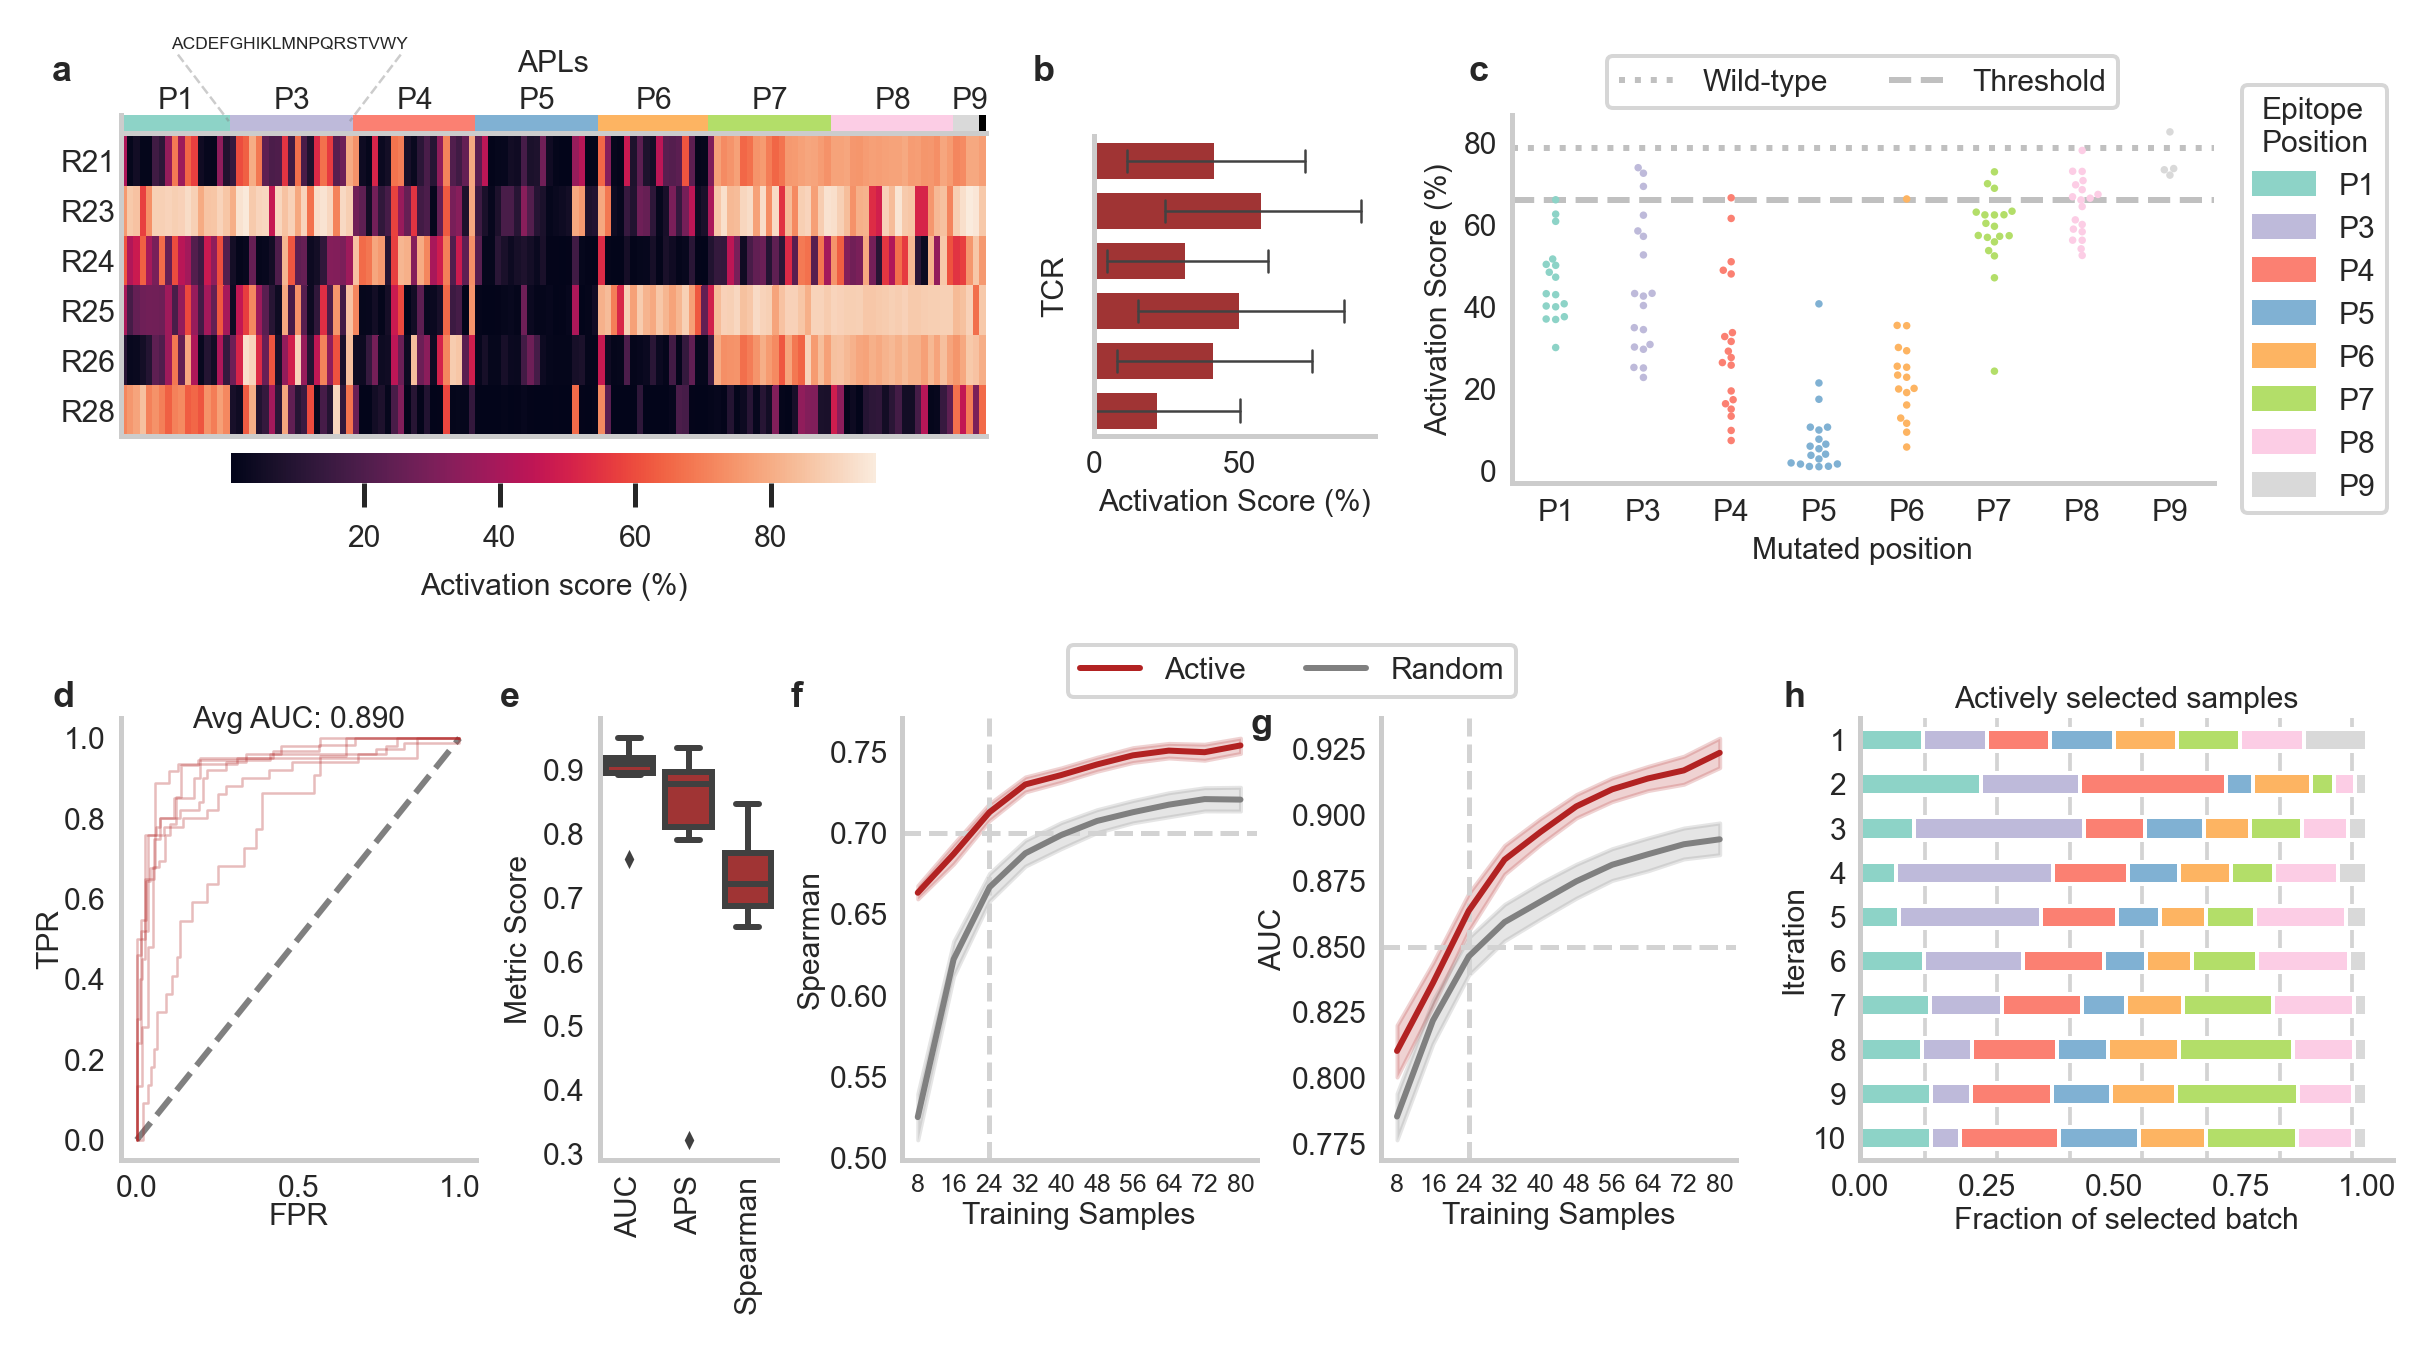

In [25]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.55), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_1-9'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[0.25, 0.3],
    width_ratios=[1],
    #hspace=0.4
)

gridspecs['gs_1234'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-9'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.1,
    #hspace=0.25,
)

gridspecs['gs_2-4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1234'][1],
    nrows=1,
    ncols=3,
    height_ratios=[1, ],
    width_ratios=[2, 5, 0.3],
    wspace=0.4,
    #hspace=0.25,
)

gridspecs['gs_4-9'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-9'][1],
    nrows=1,
    ncols=5,
    height_ratios=[1],
    width_ratios=[1, 0.5, 1, 1, 1.5],
    wspace=0.35,
)

axes['ax_c'] = fig.add_subplot(gridspecs['gs_2-4'][1])
axes['ax_legend'] = fig.add_subplot(gridspecs['gs_2-4'][2])
axes['ax_legend'].axis('off')

plot_activation_heatmap(data_human_norm, gridspecs['gs_1234'][0], fig)
axes['ax_b'] = plot_tcrs_averaged(data_human_norm, gridspecs['gs_2-4'][0], fig=fig)
plot_epitopes(data_human_norm, axes['ax_c'], do_legend=True, base_epitope='VPSVWRSSL', threshold=66.09)
plot_legend(axes['ax_legend'])

fig.text(0.069, 0.975, 'ACDEFGHIKLMNPQRSTVWY', size='xx-small')
line_left = mpl.lines.Line2D([0.072, 0.093], [0.97, 0.92], linestyle='dashed', linewidth=0.5, color='gray', alpha=0.4)
line_right = mpl.lines.Line2D([0.164, 0.143], [0.97, 0.92], linestyle='dashed', linewidth=0.5, color='gray', alpha=0.4)
fig.add_artist(line_left)
fig.add_artist(line_right)


axes['ax_d'] = fig.add_subplot(gridspecs['gs_4-9'][0])
axes['ax_e'] = fig.add_subplot(gridspecs['gs_4-9'][1])

plot_auc(ppdf[ppdf['Repertoire']=='Human'], axes['ax_d'], xlabel='FPR', ylabel='TPR')
plot_metric_boxplot(['Spearman', 'AUC', 'APS'], axes['ax_e'])


axes['ax_f'] = fig.add_subplot(gridspecs['gs_4-9'][2])
axes['ax_g'] = fig.add_subplot(gridspecs['gs_4-9'][3])
axes['ax_h'] = fig.add_subplot(gridspecs['gs_4-9'][4])

groups = [i//8 for i in range(80)]
xticks = [8+8*i for i in range(10)]

plot_performance(results_within_human, 'Spearman', ['Active', 'Random'], ax=axes['ax_f'], xticks=xticks)
plot_performance(results_within_human, 'auc', ['Active', 'Random'], ax=axes['ax_g'], xticks=xticks, 
                 legend=True)

plot_used_apls(apls_within_human['Active'], groups=groups, ax=axes['ax_h'], xticks=xticks, 
               title='Actively selected samples')

fig.text(0.02, 0.95, 'a', size='large', weight='bold')
fig.text(0.425, 0.95, 'b', size='large', weight='bold')
fig.text(0.605, 0.95, 'c', size='large', weight='bold')
fig.text(0.02, 0.48, 'd', size='large', weight='bold')
fig.text(0.205, 0.48, 'e', size='large', weight='bold')
fig.text(0.325, 0.48, 'f', size='large', weight='bold')
fig.text(0.515, 0.46, 'g', size='large', weight='bold')
fig.text(0.735, 0.48, 'h', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_fig5_dataHuman_withinPrediction.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_fig5_dataHuman_withinPrediction.png', dpi=DPI, bbox_inches='tight')

## Sup. Raw Data human

<ipython-input-26-8e0357215422>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


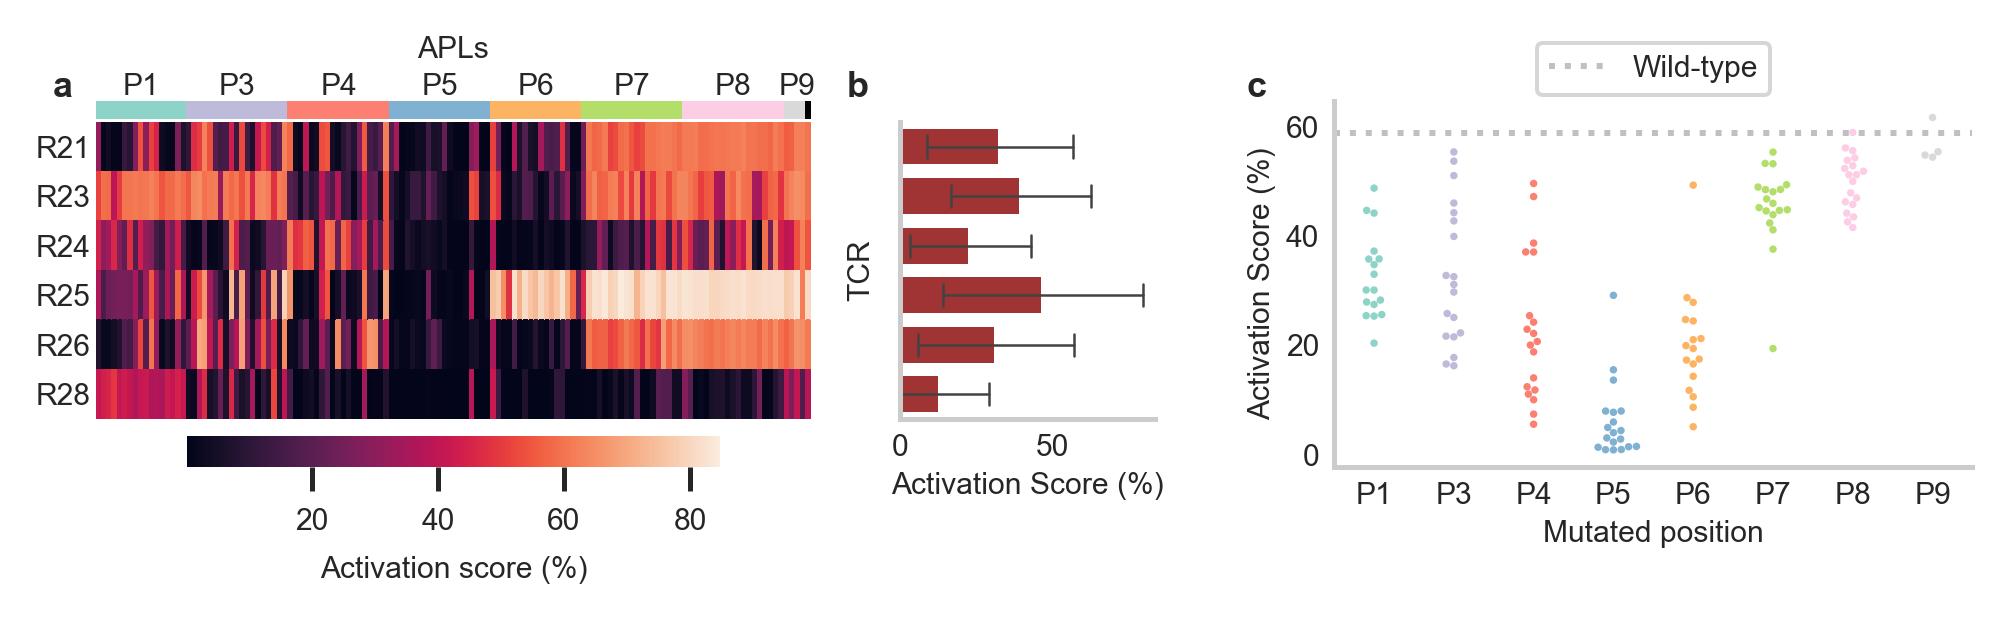

In [26]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.2), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_123'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.1,
    #hspace=0.25,
)

gridspecs['gs_23'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1, ],
    width_ratios=[2, 5],
    wspace=0.4,
    #hspace=0.25,
)

axes['ax_c'] = fig.add_subplot(gridspecs['gs_23'][1])

plot_activation_heatmap(data_human_unnorm, gridspecs['gs_123'][0], fig)
axes['ax_b'] = plot_tcrs_averaged(data_human_unnorm, gridspecs['gs_23'][0], fig=fig)
plot_epitopes(data_human_unnorm, axes['ax_c'], threshold=None, do_legend=True)


fig.text(0.107, 0.888, 'a', size='large', weight='bold')
fig.text(0.435, 0.888, 'b', size='large', weight='bold')
fig.text(0.6, 0.888, 'c', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_supp_dataHumanUnnormalized.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_dataHumanUnnormalized.png', dpi=DPI, bbox_inches='tight')


## Sup. Feature Testing

<ipython-input-27-afa036eeb42c>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


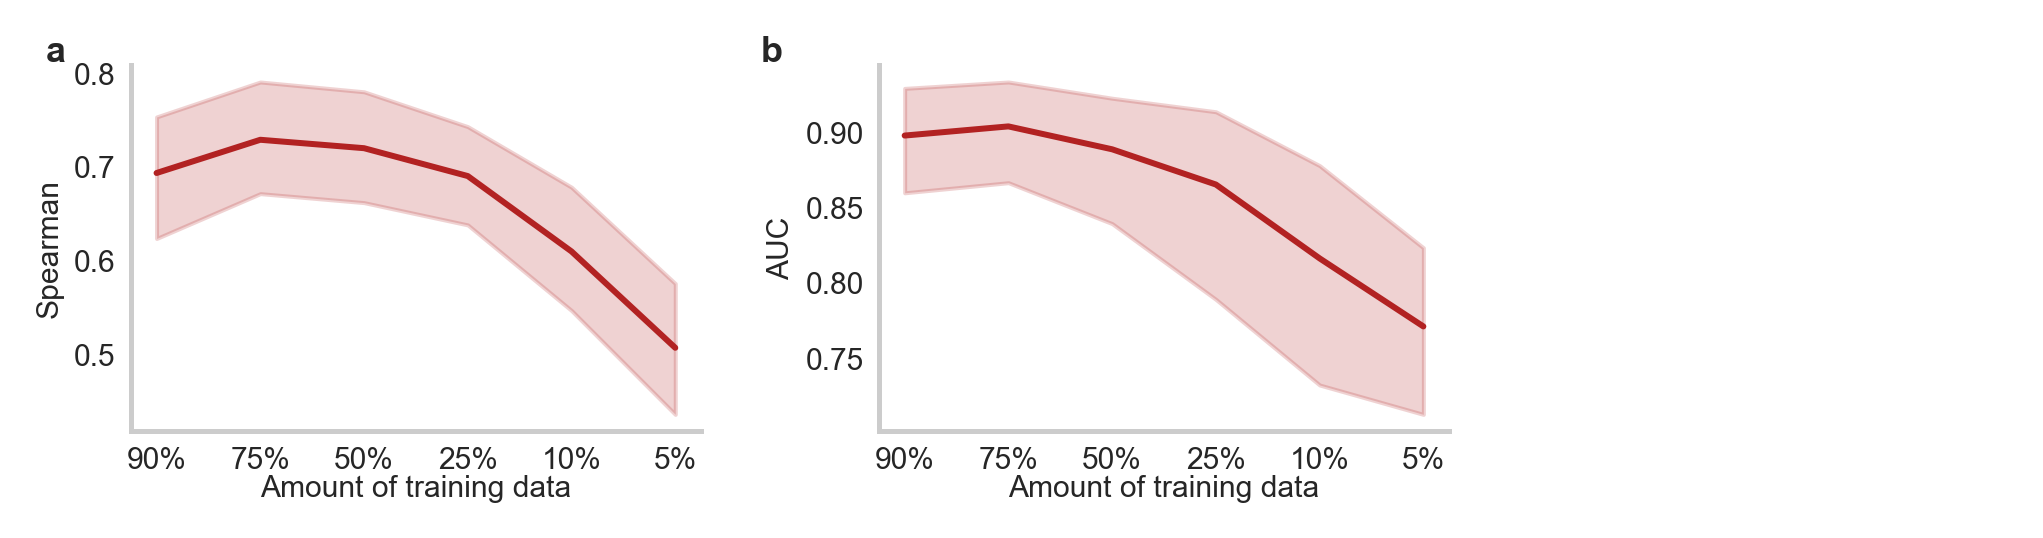

In [27]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.2), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=3,
    height_ratios=[1],
    width_ratios=[1.5, 1.5, 1],
    wspace=0.35,
    #hspace=0.25,
)

axes['ax_a'] = fig.add_subplot(gridspecs['gs'][0])
axes['ax_b'] = fig.add_subplot(gridspecs['gs'][1])
axes['ax_c'] = fig.add_subplot(gridspecs['gs'][2])
axes['ax_c'].axis('off')


plot_data_size(axes['ax_a'])

plot_data_size(axes['ax_b'], metric='AUC')

fig.text(0.09, 0.888, 'a', size='large', weight='bold')
fig.text(0.385, 0.888, 'b', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_supp_datasizeHuman.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_datasizeHuman.png', dpi=DPI, bbox_inches='tight')


## Paper numbers

In [28]:
(data_human_norm[:-1] > 66.09).sum()

R21    50
R23    75
R24    22
R25    62
R26    50
R28    20
dtype: int64

In [29]:
df_tmp = (data_human_norm>66.09)
df_tmp['pos'] = df_tmp.index.str[0]
df_tmp.groupby('pos').sum()

,R21,R23,R24,R25,R26,R28
pos,,,,,,
0,1,1,1,1,1,1
1,1,16,0,0,2,13
3,5,18,1,5,5,4
4,5,1,10,2,4,0
5,0,2,0,0,0,0
6,0,2,0,14,0,1
7,16,17,3,18,16,0
8,19,15,6,19,19,0
9,4,4,2,4,4,2


### Prediction

In [30]:
pd.set_option('display.expand_frame_repr', False)
print('---  summary statistics\n',
      lmdf.query('Split=="LMO"') \
          .groupby(['Metric', 'Repertoire'])['Value'].describe())

---  summary statistics
                            count       mean       std        min        25%        50%        75%        max
Metric         Repertoire                                                                                   
APS            Human         6.0   0.783675  0.230869   0.322415   0.811189   0.877290   0.896481   0.933024
AUC            Human         6.0   0.889605  0.066015   0.760647   0.895153   0.908312   0.917439   0.949114
MAE            Human         6.0  13.672150  1.821629  11.862865  12.474555  12.969578  14.852846  16.440726
Pearson        Human         6.0   0.778021  0.080855   0.662654   0.724746   0.785791   0.848579   0.859982
R2             Human         6.0   0.608025  0.125947   0.436736   0.520270   0.613997   0.720089   0.738941
Spearman       Human         6.0   0.734336  0.070428   0.654240   0.686838   0.722096   0.770668   0.845638
Spearman_class Human         6.0   0.673857  0.105293   0.546274   0.585722   0.693498   0.742686   0.8

In [31]:
lmdf.query('Metric=="Spearman"').groupby(['Metric', 'Repertoire', 'Split'])['Value'].mean()

Metric    Repertoire  Split
Spearman  Human       L10O     0.693444
                      L25O     0.728874
                      L50O     0.719897
                      L75O     0.690192
                      L90O     0.609804
                      L95O     0.507070
                      LAO      0.770377
                      LMO      0.734336
                      LPO      0.106106
Name: Value, dtype: float64

In [32]:
lmdf.query('Metric=="AUC"').groupby(['Metric', 'Repertoire', 'Split'])['Value'].mean()

Metric  Repertoire  Split
AUC     Human       L10O     0.902920
                    L25O     0.903754
                    L50O     0.888554
                    L75O     0.865182
                    L90O     0.815993
                    L95O     0.778462
                    LAO      0.941437
                    LMO      0.889605
                    LPO      0.511233
Name: Value, dtype: float64

In [33]:
print('---  human\n')
print(lmdf.query('Split=="LMO"&Metric=="AUC"&Repertoire=="Human"') \
      .sort_values('Value'))
print()
print(lmdf.query('Split=="LMO"&Metric=="APS"&Repertoire=="Human"') \
      .sort_values('Value'))

---  human

      tcr Split  fold Metric     Value Repertoire
2672  R24   LMO   NaN    AUC  0.760647      Human
2671  R23   LMO   NaN    AUC  0.891609      Human
2670  R21   LMO   NaN    AUC  0.905783      Human
2675  R28   LMO   NaN    AUC  0.910841      Human
2674  R26   LMO   NaN    AUC  0.919639      Human
2673  R25   LMO   NaN    AUC  0.949114      Human

      tcr Split  fold Metric     Value Repertoire
2138  R24   LMO   NaN    APS  0.322415      Human
2141  R28   LMO   NaN    APS  0.790871      Human
2137  R23   LMO   NaN    APS  0.872143      Human
2136  R21   LMO   NaN    APS  0.882436      Human
2140  R26   LMO   NaN    APS  0.901163      Human
2139  R25   LMO   NaN    APS  0.933024      Human


In [34]:
print('---  spearman by position averaging spearman of individual tcrs\n',
      ppdf.query('features=="lpo"').groupby(['fold', 'tcr']).apply(
          lambda g: pd.Series(stats.spearmanr(g['act'], g['pred']), index=['rho', 'p'])
          ).reset_index().groupby('fold').mean().describe()
)

---  spearman by position averaging spearman of individual tcrs
             rho         p
count  8.000000  8.000000
mean   0.106106  0.525507
std    0.097905  0.134998
min   -0.042624  0.331184
25%    0.039369  0.445828
50%    0.132608  0.559441
75%    0.179043  0.604153
max    0.215765  0.693720


In [35]:
print('---  spearman by amino acid averaging spearman of individual tcrs\n',
      ppdf.query('features=="lao"').groupby(['fold', 'tcr']).apply(
          lambda g: pd.Series(stats.spearmanr(g['act'], g['pred']), index=['rho', 'p'])
          ).reset_index().groupby('fold').mean().describe()
)

---  spearman by amino acid averaging spearman of individual tcrs
              rho          p
count  20.000000  20.000000
mean    0.770377   0.090470
std     0.091283   0.069344
min     0.500000   0.010403
25%     0.731548   0.043407
50%     0.771825   0.071032
75%     0.822619   0.117949
max     0.916667   0.284290


In [36]:
# t-test to find significance of split performance reduction
print('---  data size hypothesis testing')

for m in ['Spearman', 'AUC']:
    print(m)
    lmdf.query(f'Metric == "{m}"').groupby(['Split', 'tcr'])['Value'].mean().reset_index()

    for r in ['Human']:
        print(f'---- {r}')
        lmo_aps = lmdf.query(f'Split=="LMO" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
        for split in lmdf['Split'].unique():
            if split == 'LMO':
                continue

            split_aps = lmdf.query(f'Split=="{split}" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
            assert np.all(lmo_aps.index == split_aps.index)
            tr = stats.wilcoxon(lmo_aps, split_aps, alternative='greater')
            md = split_aps.mean() - lmo_aps.mean()
            sd = np.sqrt((split_aps.var() + lmo_aps.var()) / 2)

            print(f'split {split} vs. LMO - mean difference {md:.4f} - effect size {md / sd:.4f} - W: {tr.statistic:.4f} , p: {tr.pvalue:.3e}')
    print(f'---- all')
    lmo_aps = lmdf.query(f'Split=="LMO" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
    for split in lmdf['Split'].unique():
        if split == 'LMO':
            continue

        split_aps = lmdf.query(f'Split=="{split}" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
        assert np.all(lmo_aps.index == split_aps.index)
        tr = stats.wilcoxon(lmo_aps, split_aps, alternative='greater')
        md = split_aps.mean() - lmo_aps.mean()
        sd = np.sqrt((split_aps.var() + lmo_aps.var()) / 2)

        print(f'split {split} vs. LMO - mean difference {md:.4f} - effect size {md / sd:.4f} - W: {tr.statistic:.4f} , p: {tr.pvalue:.3e}')
    print('')
    print('---')

---  data size hypothesis testing
Spearman
---- Human
split L10O vs. LMO - mean difference -0.0409 - effect size -0.5001 - W: 19.0000 , p: 4.688e-02
split L25O vs. LMO - mean difference -0.0055 - effect size -0.0718 - W: 12.0000 , p: 4.219e-01
split L50O vs. LMO - mean difference -0.0144 - effect size -0.1859 - W: 17.0000 , p: 1.094e-01
split L75O vs. LMO - mean difference -0.0441 - effect size -0.6051 - W: 20.0000 , p: 3.125e-02
split L90O vs. LMO - mean difference -0.1245 - effect size -1.5276 - W: 21.0000 , p: 1.562e-02
split L95O vs. LMO - mean difference -0.2273 - effect size -2.5792 - W: 21.0000 , p: 1.562e-02
split LAO vs. LMO - mean difference 0.0360 - effect size 0.4890 - W: 0.0000 , p: 1.000e+00
split LPO vs. LMO - mean difference -0.6282 - effect size -5.0717 - W: 21.0000 , p: 1.562e-02
---- all
split L10O vs. LMO - mean difference -0.0409 - effect size -0.5001 - W: 19.0000 , p: 4.688e-02
split L25O vs. LMO - mean difference -0.0055 - effect size -0.0718 - W: 12.0000 , p: 4.

In [37]:
print('Spearman of LPO: \n',
    lmdf.query(f'Metric == "Spearman" & Split == "LPO"').groupby(['Repertoire'])['Value'].mean().reset_index())

print('\nAUC of LPO: \n',
    lmdf.query(f'Metric == "AUC" & Split == "LPO"').groupby(['Repertoire'])['Value'].mean().reset_index())

Spearman of LPO: 
   Repertoire     Value
0      Human  0.106106

AUC of LPO: 
   Repertoire     Value
0      Human  0.511233


In [38]:
print('Spearman of LPO: \n',
    lmdf.query(f'Metric == "Spearman" & Split == "LPO"')['Value'].mean())

print('\nAUC of LPO: \n',
    lmdf.query(f'Metric == "AUC" & Split == "LPO"')['Value'].mean())

Spearman of LPO: 
 0.10610572944845371

AUC of LPO: 
 0.5112330188485651


In [39]:
tmp = lmdf[(lmdf['Split']=='LMO') & (lmdf['Metric'].isin(['APS', 'AUC', 'Spearman']))
    ][['tcr', 'Metric', 'Value']].pivot(columns='Metric', index='tcr').sort_values('tcr').round(3)
tmp

Value                
Metric    APS    AUC Spearman
tcr                          
R21     0.882  0.906    0.682
R23     0.872  0.892    0.744
R24     0.322  0.761    0.700
R25     0.933  0.949    0.846
R26     0.901  0.920    0.780
R28     0.791  0.911    0.654

In [40]:
tmp.mean()

       Metric  
Value  APS         0.783500
       AUC         0.889833
       Spearman    0.734333
dtype: float64

In [41]:
tmp['Value']['Spearman'].sort_values()

tcr
R28    0.654
R21    0.682
R24    0.700
R23    0.744
R26    0.780
R25    0.846
Name: Spearman, dtype: float64

## Numbers Active learning

In [42]:
dfs_results = []
for metric in ['Spearman', 'auc']:
    for method in ['Random', 'Active']:
        df = pd.DataFrame(results_within_human[method][metric])
        columns = ['tcr', 'educated', 'iteration', 'value'] if len(df.columns) == 4 else ['tcr', 'iteration', metric]
        df.columns = columns
        df['method'] = method
        df['metric'] = metric
        dfs_results.append(df)
res_human = pd.concat(dfs_results)
res_human = res_human.drop(columns=['educated'])

In [43]:
for metric in ['auc', 'Spearman']:
    print(f'-{metric}')
    for i in range(10):
        df_act = res_human.query(f'metric=="{metric}" & method=="Active" & iteration=={i}')
        df_rdm = res_human.query(f'metric=="{metric}" & method=="Random" & iteration=={i}')
        mean_act = df_act['value'].mean()
        mean_rdm = df_rdm['value'].mean()
        t_test = stats.ttest_ind(df_act[~df_act['value'].isna()]['value'].values, 
                                 df_rdm[~df_rdm['value'].isna()]['value'].values)
        print(f'It {i}: Active={mean_act:.3f} - Random={mean_rdm:.3f} - Diff={mean_act-mean_rdm:.3f} - pval={t_test[1]}')

-auc
It 0: Active=0.810 - Random=0.785 - Diff=0.025 - pval=0.00019255565248000496
It 1: Active=0.836 - Random=0.822 - Diff=0.014 - pval=0.015456722619436751
It 2: Active=0.864 - Random=0.846 - Diff=0.017 - pval=0.0009545515496676699
It 3: Active=0.883 - Random=0.859 - Diff=0.024 - pval=1.2977926177190558e-07
It 4: Active=0.894 - Random=0.867 - Diff=0.026 - pval=8.864747336635791e-10
It 5: Active=0.903 - Random=0.875 - Diff=0.028 - pval=2.148757313678911e-12
It 6: Active=0.910 - Random=0.881 - Diff=0.029 - pval=7.968938382847983e-13
It 7: Active=0.914 - Random=0.885 - Diff=0.029 - pval=5.611776560641012e-13
It 8: Active=0.917 - Random=0.889 - Diff=0.028 - pval=6.549757680139323e-12
It 9: Active=0.924 - Random=0.891 - Diff=0.033 - pval=1.8213866927212215e-14
-Spearman
It 0: Active=0.663 - Random=0.525 - Diff=0.138 - pval=1.9662654300313317e-69
It 1: Active=0.687 - Random=0.622 - Diff=0.065 - pval=1.337682285359429e-24
It 2: Active=0.713 - Random=0.667 - Diff=0.046 - pval=2.25340777935471

In [44]:
groups = [i//8 for i in range(80)]

df_apl = apls_within_human['Active']
df_tmp = df_apl[[col for col in df_apl.columns if str(col).startswith('pos')]]
df_tmp = df_tmp.apply(lambda x: x.value_counts())
df_tmp = df_tmp.fillna(0)
df_tmp = df_tmp.transpose()

if groups is not None:
    df_tmp['groups'] = groups
    df_tmp = df_tmp.groupby('groups').sum()
    df_tmp = df_tmp.div(df_tmp.sum(axis=1), axis=0)
df_apls_human = df_tmp
df_apls_human

,1,3,4,5,6,7,8,9
groups,,,,,,,,
0,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000
1,0.238542,0.194583,0.289167,0.051875,0.115417,0.043958,0.042708,0.023750
2,0.106042,0.334583,0.121250,0.116250,0.091458,0.101875,0.090208,0.038333
3,0.071458,0.308958,0.146875,0.101250,0.103542,0.084583,0.126042,0.057292
4,0.076458,0.280833,0.148333,0.086250,0.090000,0.097292,0.178333,0.042500
5,0.125625,0.196042,0.158333,0.083125,0.090833,0.128125,0.182083,0.035833
6,0.137292,0.142917,0.156875,0.088125,0.111458,0.177917,0.159792,0.025625
7,0.122708,0.097500,0.168958,0.100625,0.140000,0.224167,0.120625,0.025417
8,0.140625,0.078333,0.160208,0.114583,0.130000,0.239583,0.107917,0.028750


In [45]:
(df_apls_human.sum() / 10)

1    0.128312
3    0.181542
4    0.167125
5    0.102521
6    0.113021
7    0.140083
8    0.124354
9    0.043042
dtype: float64

## Regression Metrics on Classification Training

No handles with labels found to put in legend.
<ipython-input-59-fbb7e7e528a4>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


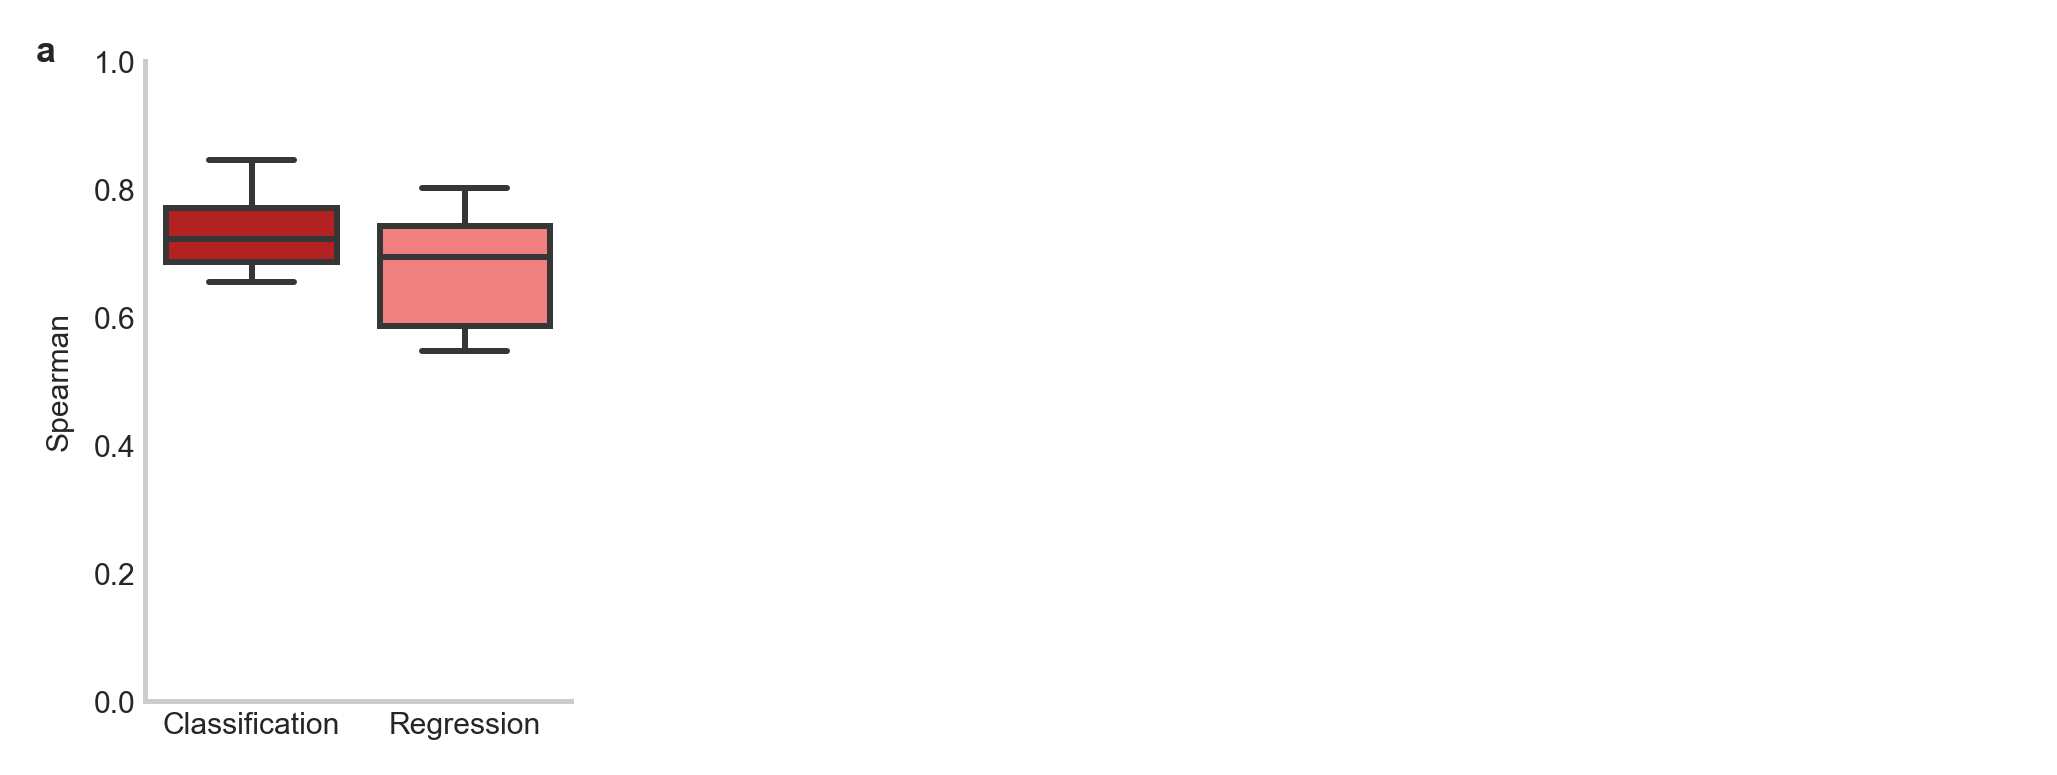

In [59]:
import matplotlib.patches as mpatches

df_plot = lmdf[lmdf['Metric'].str.contains('Spearman')
    & (lmdf['Split']=='LMO')]

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.35), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_1-2'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 3],
    #wspace=0.1,
    hspace=0.25,
)

ax_false = fig.add_subplot(gridspecs['gs_1-2'][0])
ax_true = fig.add_subplot(gridspecs['gs_1-2'][1])

sb.boxplot(data=df_plot, x='Metric', y='Value', ax=ax_false)
ax_false.grid(False)
sb.despine(ax=ax_false)
ax_false.set_ylabel('Spearman')

for i, art in enumerate(ax_false.artists):
    c = palette_tcrs['Human']
    art.set_facecolor(c)
    if i%2==1:
        art.set_facecolor('lightcoral')


ax_false.tick_params(axis='both', length=0, pad=2)
ax_false.set_xlabel(None, labelpad=1)
ax_false.set_xticklabels(['Classification', 'Regression'])
ax_false.set_ylim(0, 1)

ax_false.legend().remove()
ax_true.axis('off')

fig.text(0.08, 0.88, 'a', size='large', weight='bold')
fig.tight_layout()

In [47]:
df_plot.groupby(['Metric', 'Repertoire'])['Value'].mean()

Metric          Repertoire
Spearman        Human         0.734336
Spearman_class  Human         0.673857
Name: Value, dtype: float64

## Positionwise Testing

In [48]:
def compute_class_score(g):
    return pd.Series({
        'Accuracy': (metrics.accuracy_score(g['is_activated'], g['pred_bin'])),
    })

In [49]:
ppdf['pred_bin'] = ppdf['pred_prob'] > 0.5
df_acc = ppdf.query('features=="lmo"') \
        .groupby(['features', 'tcr', 'mut_pos']) \
        .apply(compute_class_score).reset_index()
#acc = acc.rename(columns={0: 'Accuracy'})
df_acc['Repertoire'] = 'Human'
df_acc['mut_pos'] = df_acc['mut_pos'] + 1
df_acc.groupby('Repertoire')['Accuracy'].mean()

Repertoire
Human    0.876193
Name: Accuracy, dtype: float64

<ipython-input-61-f0b6e8700a3f>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


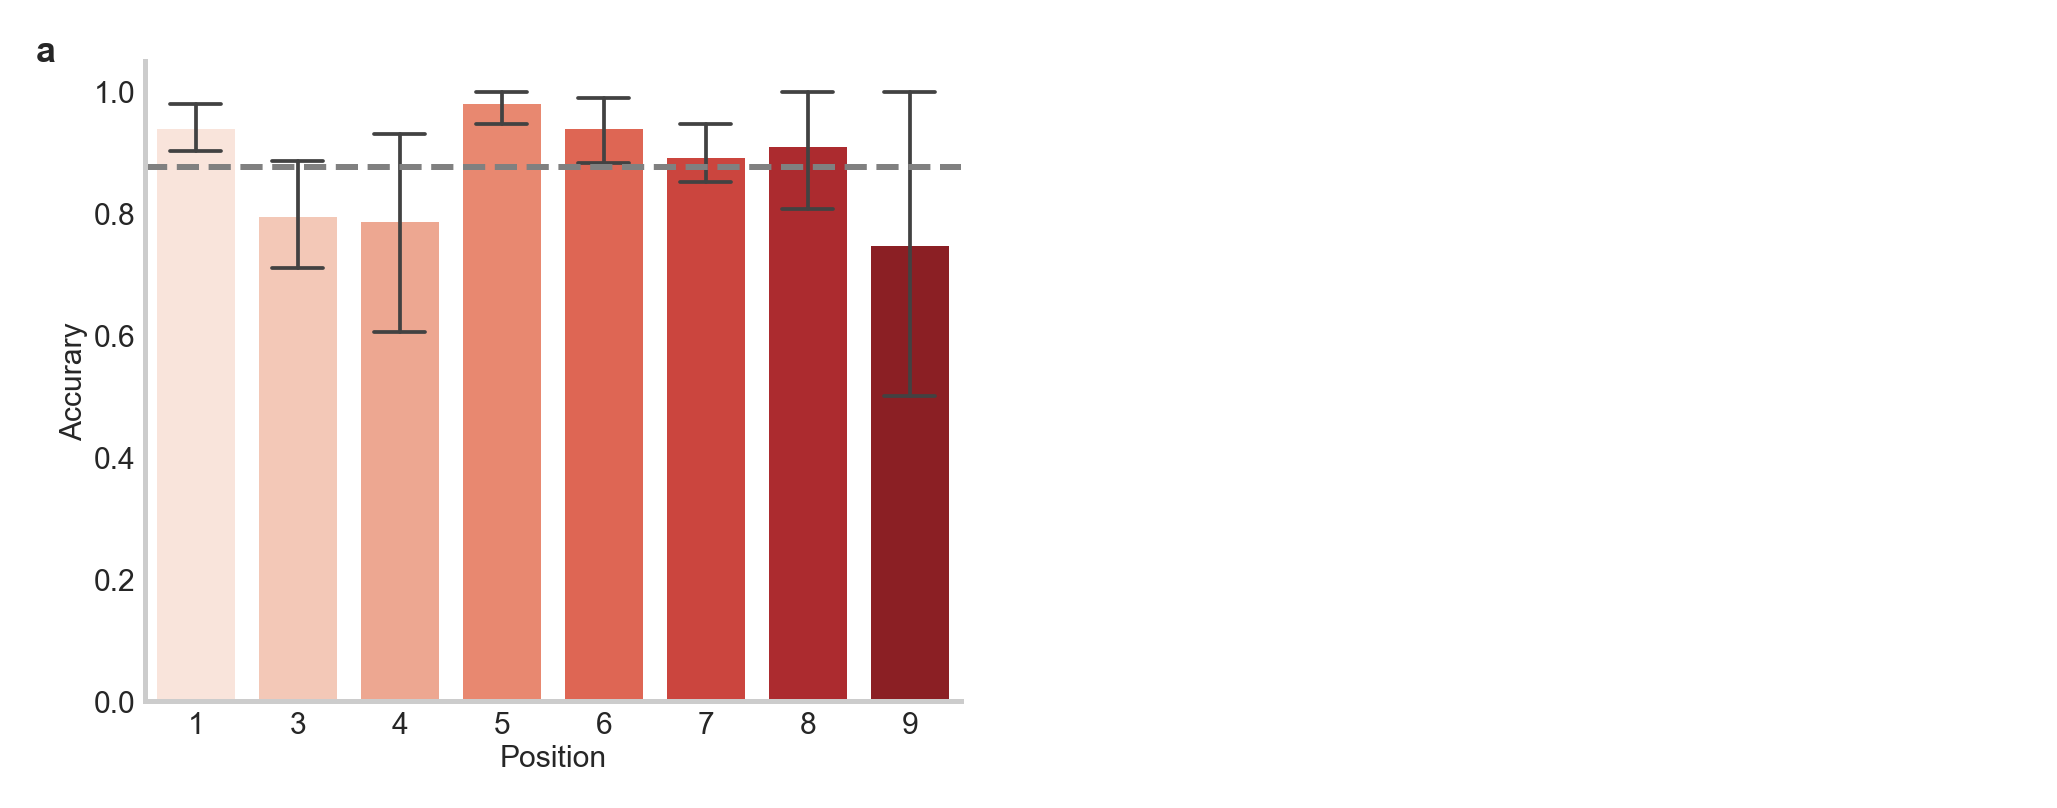

In [61]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.35), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_1-2'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.3,
    #hspace=0.4,
)

ax = fig.add_subplot(gridspecs['gs_1-2'][0])
sb.barplot(data=df_acc, y='Accuracy', x='mut_pos', ax=ax, palette='Reds', errwidth=0.75, capsize=0.5)
sb.despine(ax=ax)
ax.axhline(df_acc['Accuracy'].mean(), color='gray', linestyle='--')
ax.grid(False)
ax.set_ylabel('Accurary', labelpad=1)
ax.tick_params(axis='both', length=0, pad=2)
ax.set_xlabel('Position', labelpad=1)

ax_empty = fig.add_subplot(gridspecs['gs_1-2'][1])
ax_empty.axis('off')

fig.text(0.08, 0.88, 'a', size='large', weight='bold')

fig.tight_layout()
#fig.savefig('figures/manuscript_supp_poswiseAccVsDistance.pdf', dpi=DPI, bbox_inches='tight')
#fig.savefig('figures/manuscript_supp_poswiseAccVsDistance.png', dpi=DPI, bbox_inches='tight')

## Positionwise Accuracy through distance matric

In [51]:
def index_2_epitope(ind):
    base_epitope = 'VPSVWRSSL'    
    pos = int(ind.split('_')[0])-1
    aminos = 'ACDEFGHIKLMNPQRSTVWY'.replace(base_epitope[pos], '')
    aa = ind.split('_')[1]
    epitope = base_epitope[:pos] + aa + base_epitope[pos+1:]
    return epitope
    
df_sim = data_human_norm[data_human_norm.index!='0_0'].copy()
df_sim['APL'] = df_sim.index.map(index_2_epitope)
df_sim['mut_pos'] = df_sim.index.str.split('_').str[0]
df_sim

,R21,R23,R24,R25,R26,R28,APL,mut_pos
1_R,40.891720,75.733138,61.997226,39.805825,10.644313,71.600688,RPSVWRSSL,1
1_A,1.522293,86.730205,41.816921,17.691478,2.550953,75.387263,APSVWRSSL,1
1_S,4.955414,85.483871,47.850208,25.242718,2.649573,78.399312,SPSVWRSSL,1
1_K,1.248408,57.478006,63.869626,27.184466,5.483235,84.939759,KPSVWRSSL,1
1_H,1.127389,73.607038,39.459085,28.101402,9.513478,70.567986,HPSVWRSSL,1
...,...,...,...,...,...,...,...,...
8_W,75.923567,71.334311,61.095700,88.619202,78.106509,23.580034,VPSVWRSWL,8
9_M,71.528662,88.343109,54.854369,83.387271,74.884944,67.125645,VPSVWRSSM,9
9_F,72.547771,92.448680,57.489598,84.951456,79.158448,45.697074,VPSVWRSSF,9
9_I,79.108280,95.527859,75.312067,89.104639,86.653517,69.707401,VPSVWRSSI,9


In [52]:
def aa_dif(base, apl):
    aa_ex = None
    for i, j in zip(base, apl):
        if i != j:
            return i, j
    raise ValueError
    
df_blosum = {
    'A': [ 4, -1, -2, -2,  0, -1, -1,  0, -2, -1, -1, -1, -1, -2, -1,  1,  0, -3, -2, 0],
    'R': [-1,  5,  0, -2, -3,  1,  0, -2,  0, -3, -2,  2, -1, -3, -2, -1, -1, -3, -2, -3],
    'N': [-2,  0,  6,  1, -3,  0,  0,  0,  1, -3, -3,  0, -2, -3, -2,  1,  0, -4, -2, -3],
    'D': [-2, -2,  1,  6, -3,  0,  2, -1, -1, -3, -4, -1, -3, -3, -1,  0, -1, -4, -3, -3],
    'C': [ 0, -3, -3, -3,  9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1],
    'Q': [-1,  1,  0,  0, -3,  5,  2, -2,  0, -3, -2,  1,  0, -3, -1,  0, -1, -2, -1, -2],
    'E': [-1,  0,  0,  2, -4,  2,  5, -2,  0, -3, -3,  1, -2, -3, -1,  0, -1, -3, -2, -2],
    'G': [ 0, -2,  0, -1, -3, -2, -2,  6, -2, -4, -4, -2, -3, -3, -2,  0, -2, -2, -3, -3],
    'H': [-2,  0,  1, -1, -3,  0,  0, -2,  8, -3, -3, -1, -2, -1, -2, -1, -2, -2,  2, -3],
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3,  4,  2, -3,  1,  0, -3, -2, -1, -3, -1, 3],
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3,  2,  4, -2,  2,  0, -3, -2, -1, -2, -1, 1],
    'K': [-1,  2,  0, -1, -3,  1,  1, -2, -1, -3, -2,  5, -1, -3, -1,  0, -1, -3, -2, -2],
    'M': [-1, -1, -2, -3, -1,  0, -2, -3, -2,  1,  2, -1,  5,  0, -2, -1, -1, -1, -1, 1],
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1,  0,  0, -3,  0,  6, -4, -2, -2,  1,  3, -1],
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4,  7, -1, -1, -4, -3, -2],
    'S': [ 1, -1,  1,  0, -1,  0,  0,  0, -1, -2, -2,  0, -1, -2, -1,  4,  1, -3, -2, -2],
    'T': [ 0, -1,  0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1,  1,  5, -2, -2, 0],
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1,  1, -4, -3, -2, 11,  2, -3],
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3,  2, -1, -1, -2, -1,  3, -3, -2, -2,  2,  7, -1],
    'V': [ 0, -3, -3, -3, -1, -2, -2, -3, -3,  3,  1, -2,  1, -1, -2, -2,  0, -3, -1, 4],
}
cols = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
df_blosum = pd.DataFrame(df_blosum, index=cols)

def blosum_dist(base, apl):
    old, new = aa_dif(base, apl)
    # high values => high similarity
    dist = df_blosum.loc[old, new]
    return dist

atchley_factors = {
    'A': [-0.591, -1.302, -0.733, 1.570, -0.146],
    'C': [-1.343, 0.465, -0.862, -1.020, -0.255],
    'D': [1.050, 0.302, -3.656, -0.259, -3.242],
    'E': [1.357, -1.453, 1.477, 0.113, -0.837],
    'F': [-1.006, -0.590, 1.891, -0.397, 0.412],
    'G': [-0.384, 1.652, 1.330, 1.045, 2.064],
    'H': [0.336, -0.417, -1.673, -1.474, -0.078],
    'I': [-1.239, -0.547, 2.131, 0.393, 0.816],
    'K': [1.831, -0.561, 0.533, -0.277, 1.648],
    'L': [-1.019, -0.987, -1.505, 1.266, -0.912],
    'M': [-0.663, -1.524, 2.219, -1.005, 1.212],
    'N': [0.945, 0.828, 1.299, -0.169, 0.933],
    'P': [0.189, 2.081, -1.628, 0.421, -1.392],
    'Q': [0.931, -0.179, -3.005, -0.503, -1.853],
    'R': [1.538, -0.055, 1.502, 0.440, 2.897],
    'S': [-0.228, 1.399, -4.760, 0.670, -2.647],
    'T': [-0.032, 0.326, 2.213, 0.908, 1.313],
    'V': [-1.337, -0.279, -0.544, 1.242, -1.262],
    'W': [-0.595, 0.009, 0.672, -2.128, -0.184],
    'Y': [0.260, 0.830, 3.097, -0.838, 1.512],
}

def atchley_dist(base, apl):
    old, new = aa_dif(base, apl)
    old = np.array(atchley_factors[old])
    new = np.array(atchley_factors[new])
    dist = np.linalg.norm(old-new)
    # max value = 9.04 => invert with 10 to change distance to similarity
    dist = 10 - dist
    return dist

df_sim['Blosum'] = df_sim['APL'].apply(lambda x: blosum_dist('VPSVWRSSL', x))
df_sim['Atchley'] = df_sim['APL'].apply(lambda x: atchley_dist('VPSVWRSSL', x))
df_sim

,R21,R23,R24,R25,R26,R28,APL,mut_pos,Blosum,Atchley
1_R,40.891720,75.733138,61.997226,39.805825,10.644313,71.600688,RPSVWRSSL,1,-3,4.482537
1_A,1.522293,86.730205,41.816921,17.691478,2.550953,75.387263,APSVWRSSL,1,0,8.270316
1_S,4.955414,85.483871,47.850208,25.242718,2.649573,78.399312,SPSVWRSSL,1,-2,5.094327
1_K,1.248408,57.478006,63.869626,27.184466,5.483235,84.939759,KPSVWRSSL,1,-2,5.304136
1_H,1.127389,73.607038,39.459085,28.101402,9.513478,70.567986,HPSVWRSSL,1,-3,6.412365
...,...,...,...,...,...,...,...,...,...,...
8_W,75.923567,71.334311,61.095700,88.619202,78.106509,23.580034,VPSVWRSWL,8,-3,3.256960
9_M,71.528662,88.343109,54.854369,83.387271,74.884944,67.125645,VPSVWRSSM,9,2,5.105912
9_F,72.547771,92.448680,57.489598,84.951456,79.158448,45.697074,VPSVWRSSF,9,0,5.973942
9_I,79.108280,95.527859,75.312067,89.104639,86.653517,69.707401,VPSVWRSSI,9,2,5.851433


In [53]:
tcrs = [el for el in df_sim.columns if el not in ['APL', 'Blosum', 'Atchley', 'mut_pos']]

content = {
    'tcr': [],
    'mut_pos': [],
    'Metric': [],
    'Accuracy': [],
}

for distance in ['Blosum', 'Atchley']:
    for pos in range(1, 10):
        if pos == 2:
            continue
        tmp_pos = df_sim[df_sim['mut_pos']==str(pos)].copy()
        
        thresholds = [-20] + tmp_pos[distance].unique().tolist()
        tmp_pos[tcrs] = tmp_pos[tcrs] > 66.09
        
        max_t = -20
        max_acc = -99
        for t in thresholds:
            tmp_pos_pred = tmp_pos[distance]>t
            #print(t)
            #print(tmp_pos_pred)
            acc = np.sum((tmp_pos[tcrs].values == tmp_pos_pred.values[:, np.newaxis])) / (len(tmp_pos) * len(tcrs))
            #print(acc)
            if acc > max_acc:
                max_acc = acc
                max_t = t
        
        for tcr in tcrs:
            content['tcr'].append(tcr)
            content['mut_pos'].append(pos)
            content['Metric'].append(distance)
            
            tmp = df_sim[df_sim['mut_pos']==str(pos)][[tcr, distance]].copy()
            acc = np.sum((tmp[tcr]>66.09) == (tmp[distance]>max_t)) / len(tmp)
            content['Accuracy'].append(acc)

content = pd.DataFrame(content)
content.head(5)

,tcr,mut_pos,Metric,Accuracy
0,R21,1,Blosum,0.941176
1,R23,1,Blosum,0.058824
2,R24,1,Blosum,1.000000
3,R25,1,Blosum,1.000000
4,R26,1,Blosum,0.882353


<ipython-input-62-7d3a42e984d7>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Text(0.08, 0.88, 'a')

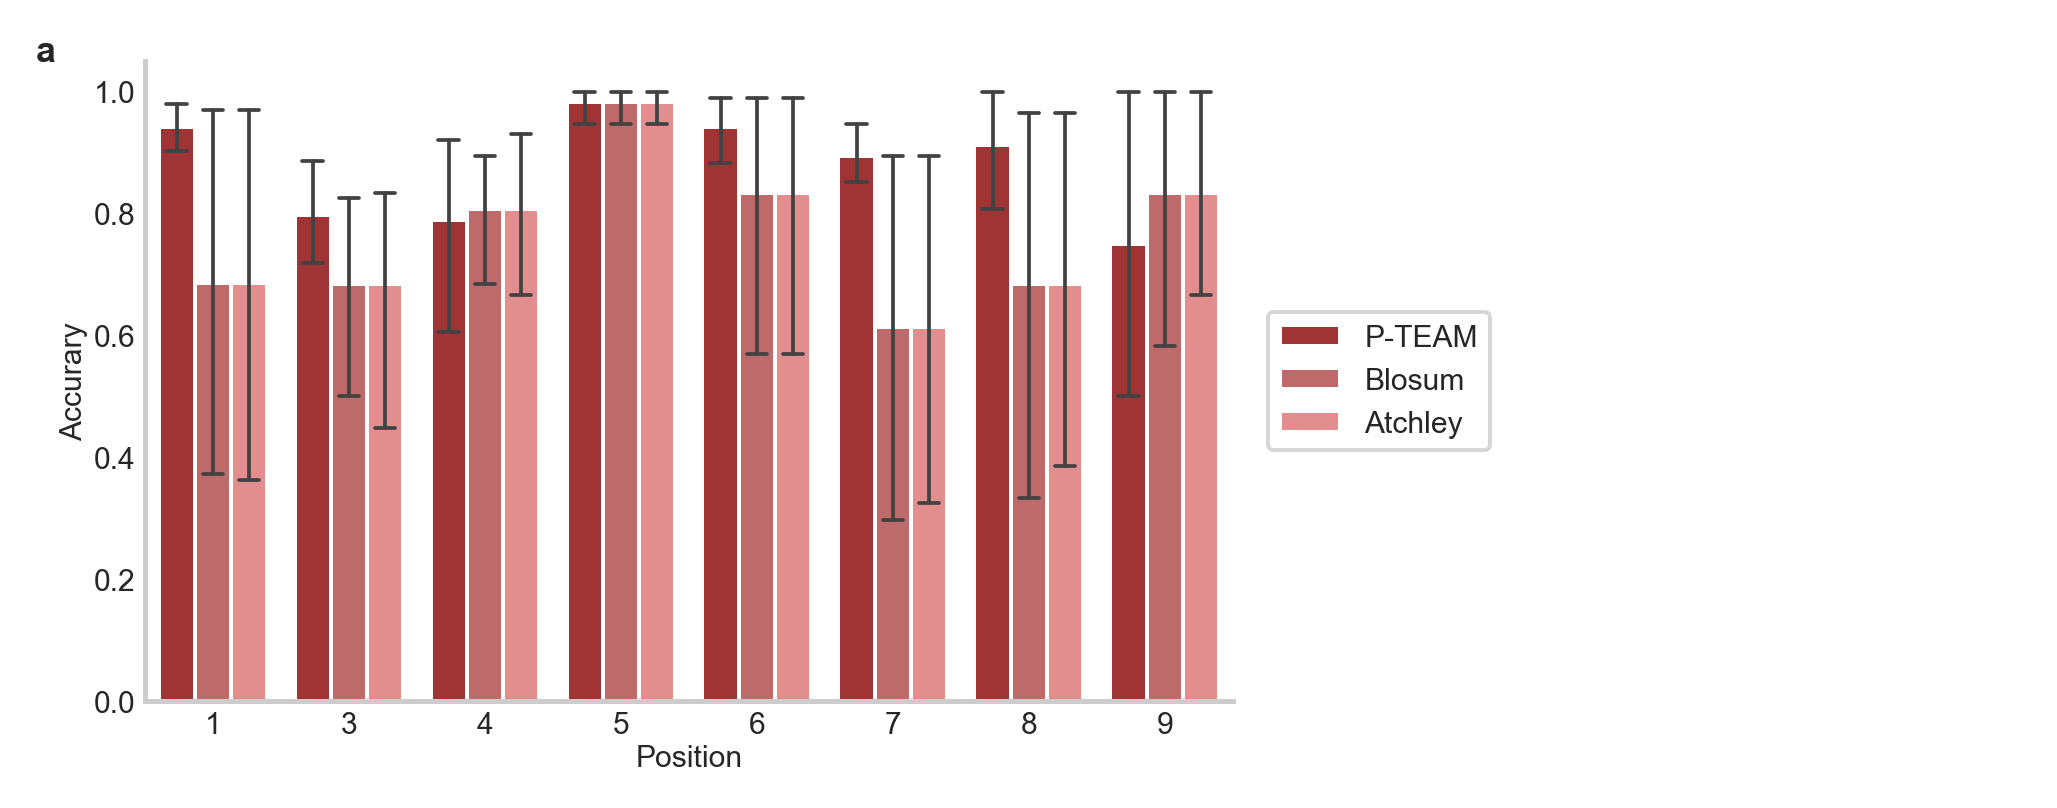

In [62]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.35), dpi=DPI)
gridspecs = {}
axes = {}

df_acc['Metric'] = 'P-TEAM'
df_dist_comp = pd.concat([df_acc, content])

gridspecs['gs_1-2'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 1],
    wspace=0.3,
    #hspace=0.4,
)

ax = fig.add_subplot(gridspecs['gs_1-2'][0])
custom_palette = ['firebrick', 'indianred', 'lightcoral']
sb.barplot(data=df_dist_comp, y='Accuracy', x='mut_pos', hue='Metric', ax=ax, 
           palette=custom_palette, errwidth=0.75, capsize=0.15)
sb.despine(ax=ax)
ax.set_xlabel('Position')
ax.grid(False)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
ax.set_ylabel('Accurary', labelpad=1)
ax.tick_params(axis='both', length=0, pad=2)
ax.set_xlabel('Position', labelpad=1)

ax_empty = fig.add_subplot(gridspecs['gs_1-2'][1])
ax_empty.axis('off')
    
#legend_patches = [mpatches.Patch(color=palette_tcrs[name], label=name) for name in reps]
#axes[1].legend(handles=legend_patches, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.2))
    
fig.tight_layout()
fig.text(0.08, 0.88, 'a', size='large', weight='bold')
#fig.savefig('figures/manuscript_supp_poswiseAccVsDistance.pdf', dpi=DPI, bbox_inches='tight')
#fig.savefig('figures/manuscript_supp_poswiseAccVsDistance.png', dpi=DPI, bbox_inches='tight')

In [55]:
df_dist_comp.groupby(['Metric'])['Accuracy'].mean()

Metric
Atchley    0.765609
Blosum     0.765609
P-TEAM     0.876193
Name: Accuracy, dtype: float64

In [56]:
df_dist_comp.groupby(['Metric', 'mut_pos'])['Accuracy'].mean()

Metric   mut_pos
Atchley  1          0.686275
         3          0.684211
         4          0.807018
         5          0.982456
         6          0.833333
         7          0.614035
         8          0.684211
         9          0.833333
Blosum   1          0.686275
         3          0.684211
         4          0.807018
         5          0.982456
         6          0.833333
         7          0.614035
         8          0.684211
         9          0.833333
P-TEAM   1          0.941176
         3          0.798246
         4          0.789474
         5          0.982456
         6          0.941176
         7          0.894737
         8          0.912281
         9          0.750000
Name: Accuracy, dtype: float64